In [1]:
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  2.4 ; cuda:  cu124
detectron2: 0.6


In [29]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random, matplotlib.pyplot as plt


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Helper functions

In [117]:
def cv2_imshow(img):
    """
    Displays an image in a Jupyter notebook using matplotlib.

    Args:
        image_path (str): Path to the image file.
    """

    # Check if the image was successfully loaded
    if img is None:
        print(f"Error: Image at {image_path} not found or failed to load.")
        return
    
    # Convert the image from BGR to RGB for correct display with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(img_rgb)
    plt.axis('off')  # Turn off the axis labels
    plt.show()

def read_random_image(directory_path):
    # Get a list of all files in the directory
    all_files = os.listdir(directory_path)
    
    # Filter out the image files (commonly supported formats)
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = [file for file in all_files if any(file.lower().endswith(ext) for ext in image_extensions)]
    
    if not image_files:
        raise ValueError("No image files found in the directory.")
    
    # Choose a random image file
    random_image = random.choice(image_files)
    
    # Construct the full path to the image
    image_path = os.path.join(directory_path, random_image)
    
    # Read the image using cv2
    img = cv2.imread(image_path)
    
    if img is None:
        raise ValueError("Failed to read the image file.")
    
    return img

# Standard Detectron2 Run

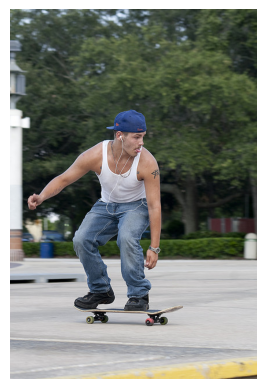

In [46]:
# Use image from local person coco dataset
im = read_random_image("./person")
cv2_imshow(im)

In [47]:
# Then, we create a detectron2 config and a detectron2 DefaultPredictor to run inference on this image.
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[09/22 15:47:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/taiga/conda/envs/clowder2-extractors/lib/python3.10/site-packages/detectron2/layers/wrappers.py:46: FutureWarning: `torch._dynamo.external_utils.is_compiling` is deprecated. Use `torch.compiler.is_compiling` instead.
  return is_compiling()
/taiga/conda/envs/clowder2-extractors/lib/python3.10/site-packages/detectron2/layers/wrappers.py:46: FutureWarning: `torch._dynamo.external_utils.is_compiling` is deprecated. Use `torch.compiler.is_compiling` instead.
  return is_compiling()
/taiga/conda/envs/clowder2-extractors/lib/python3.10/site-packages/detectron2/layers/wrappers.py:46: FutureWarning: `torch._dynamo.external_utils.is_compiling` is deprecated. Use `torch.compiler.is_compiling` instead.
  return is_compiling()
/taiga/conda/envs/clowder2-extractors/lib/python3.10/site-packages/detectron2/layers/wrappers.py:46: FutureWarning: `torch._dynamo.external_utils.is_compiling` is deprecated. Use `torch.compiler.is_compiling` instead.
  return is_compiling()
/taiga/conda/envs/clowder2-extra

In [48]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0, 36,  2,  2], device='cuda:0')
Boxes(tensor([[ 30.1485, 168.9435, 263.1754, 527.4871],
        [118.3083, 511.7484, 298.4340, 548.6874],
        [ 52.2197, 383.2245,  96.4606, 402.7244],
        [ 20.2731, 386.6362,  41.7868, 403.6224]], device='cuda:0'))


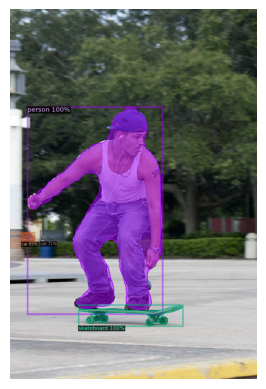

In [49]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Ray Batch Inference

In [111]:
import ray
ray.init(_temp_dir='/taiga/mohanar2/raytmp', ignore_reinit_error=True)
ray.available_resources()

2024-09-22 16:40:00,872	INFO worker.py:1586 -- Calling ray.init() again after it has already been called.


{'accelerator_type:A100': 1.0,
 'node:__internal_head__': 1.0,
 'node:192.168.100.171': 1.0,
 'CPU': 24.0,
 'object_store_memory': 71256716223.0,
 'memory': 156275000730.0,
 'GPU': 1.0}

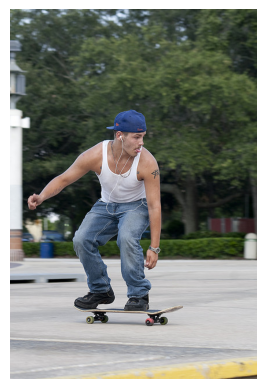

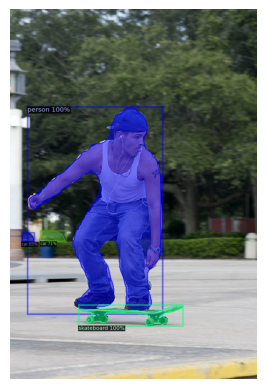

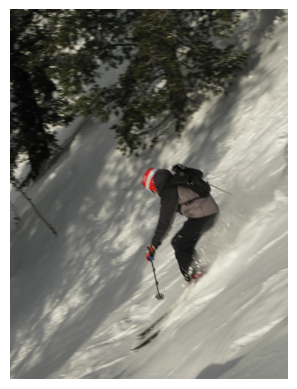

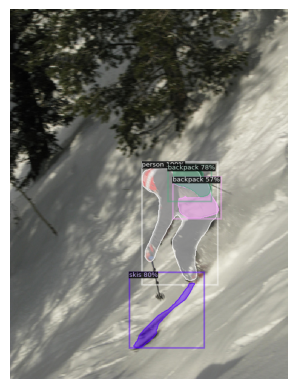

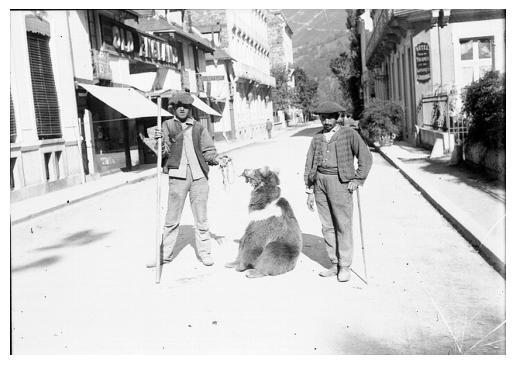

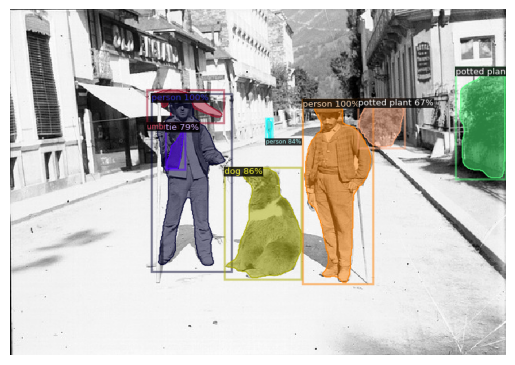

In [110]:
# Basic Ray Inference implementation is working
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a custom testing threshold
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Load the model once
def setup_model():
    predictor = DefaultPredictor(cfg)
    return predictor

# Run inference on a batch of images
@ray.remote(num_gpus=1)
def run_inference_on_batch(image):
    predictor = setup_model()
    result = {"image": image, "outputs": predictor(image)}
    return result

images = [read_random_image("./person") for _ in range(3)]
result_refs = [run_inference_on_batch.remote(image) for image in images]

while len(result_refs) > 0:
    # Wait for the next task to complete
    ready_object_ids, remaining = ray.wait(result_refs, num_returns=1)
    results = ray.get(ready_object_ids)
    for result in results:
        im = result["image"]
        outputs = result["outputs"]
        cv2_imshow(im)
        v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        cv2_imshow(out.get_image()[:, :, ::-1])
    result_refs = remaining



In [100]:
ray.shutdown()